## Project Template

In [1]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

from pyspark.context import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.jars.packages", 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0') \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-370e96d6-319e-4426-914e-f9664b94a0c2;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.0.0 in central
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.4-3 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.7.5 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 182ms :: artifacts dl 4m

Be sure to start the stream on Kafka!

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType, TimestampType, DateType

schema = StructType(
      [
        StructField("name", StringType(), False),
        StructField("price", DoubleType(), False),
        StructField("timestamp", TimestampType(), False),
      ]
    )


In [3]:
kafka_server = "kafka1:9092"   
from pyspark.sql.functions import from_json

lines = (spark.readStream                        # Get the DataStreamReader
  .format("kafka")                                 # Specify the source format as "kafka"
  .option("kafka.bootstrap.servers", kafka_server) # Configure the Kafka server name and port
  .option("subscribe", "stock")                       # Subscribe to the "en" Kafka topic 
  .option("startingOffsets", "earliest")           # The start point when a query is started
  .option("maxOffsetsPerTrigger", 100)             # Rate limit on max offsets per trigger interval
  .load()
  .select(from_json(col("value").cast("string"), schema).alias("parsed_value"))
# Load the DataFrame
)
df = lines.select("parsed_value.*")


## The assignment starts here

You can create a

## Select the N most valuable stocks in a window

In [4]:
from pyspark.sql.functions import window, col


N = 10

windowedDF = df \
        .withWatermark("timestamp", "30 seconds") \
        .groupBy(window("timestamp", "5 minutes"), "name") \
        .agg({"price": "max"})


top_stocks = windowedDF.orderBy(col("window").asc(),  col("max(price)").desc()).limit(N)
top_stocks.createOrReplaceTempView("top_stocks")


# Save results
query_1 = (top_stocks.writeStream
         .outputMode("complete")
         .format("memory")
         .queryName("MostValuableStock")
         .option("truncate", False)
         .start())



23/11/06 20:17:30 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-30c8155e-b951-491a-bed3-7090ef39033b. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


+------------------------------------------+-----+----------+
|window                                    |name |max(price)|
+------------------------------------------+-----+----------+
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|PCLN |819.98    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|GOOGL|414.2338  |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|AZO  |384.01    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|CMG  |378.4     |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|AMZN |269.98    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|GWW  |261.34    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|EQIX |219.94    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|IBM  |211.98    |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|ISRG |192.6465  |
|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|ADS  |180.39    |
+------------------------------------------+-----+----------+



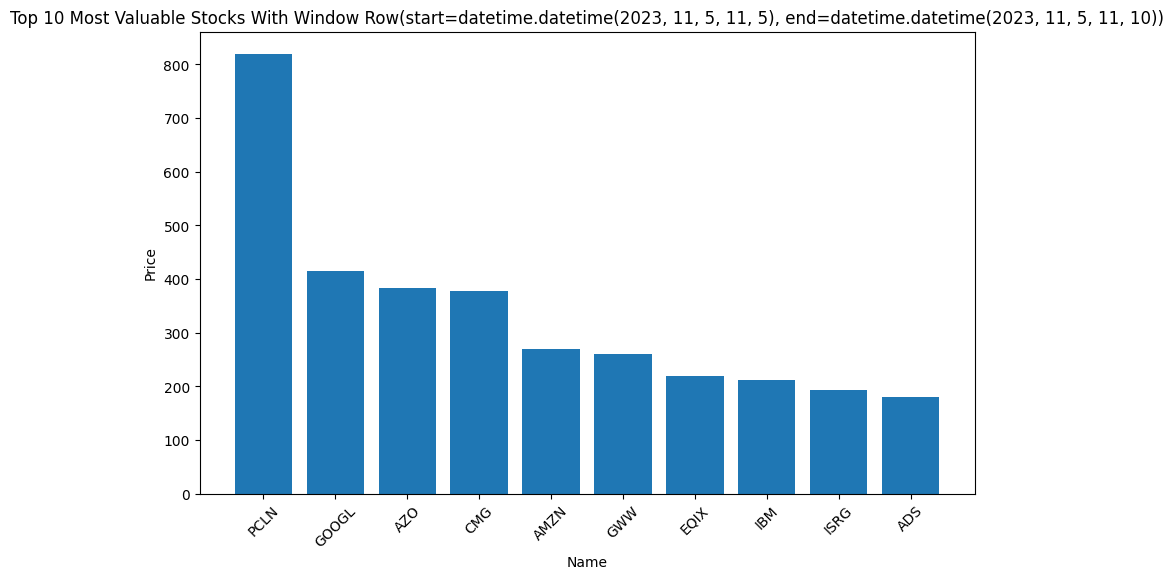

In [5]:
from matplotlib import pyplot as plt

data = spark.sql("SELECT * FROM MostValuableStock")
data.show(truncate=False)

name_list = [row["name"] for row in data.collect()]
price_list = [row["max(price)"] for row in data.collect()]
window_time = data.select("window").first()["window"]

# Plot 
plt.figure(figsize=(10, 6))
plt.bar(name_list, price_list)
plt.xlabel("Name")
plt.ylabel("Price")
plt.title(f"Top 10 Most Valuable Stocks With Window {window_time}")
plt.xticks(rotation=45)

plt.show()

## Select the stocks that lost value between two windows

In [7]:
from pyspark.sql.functions import col, lag, window

def process_batch(df, epoch_id):
    
    window_spec = Window.partitionBy("name").orderBy("window")

    # Create a column "previous_window" and "previous_price" using the lag function
    df = df.withColumn("previous_price", lag("avg(price)").over(window_spec))
    df = df.withColumn("previous_window", lag("window").over(window_spec))
    df = df.filter(df["previous_price"] > df["avg(price)"])
    
    # Show data
    df.show(truncate=False)
    

# Apply a time window to the data with a watermark of 30 seconds
# Group the data by a 5-minute window and the stock name
# Calculate the average price within each window for each stock

windowedDF_2 = df \
        .withWatermark("timestamp", "30 seconds") \
        .groupBy(window("timestamp", "5 minutes"), "name") \
        .agg({"price": "avg"})

# Order the results by average price in descending order 
lost_value_stocks = windowedDF_2.orderBy("avg(price)", ascending=False)


# Apply function process_batch, save and show result
query_2 = (lost_value_stocks.writeStream
           .outputMode("complete")
           .format("memory")
           .queryName("TheStocksThatLostValue")
           .option("truncate", False)
           .foreachBatch(process_batch)
           .start())


23/11/06 20:18:59 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-2b2ed810-dfff-41a6-bdcf-18924720e0c1. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



+------------------------------------------+----+----------+------------------+------------------------------------------+
|window                                    |name|avg(price)|previous_price    |previous_window                           |
+------------------------------------------+----+----------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56     |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|CLX |84.975    |86.4              |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|COP |60.8      |61.82             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|LB  |50.34     |51.48             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|XYL |26.63     |27.835            |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:

+------------------------------------------+----+----------+------------------+------------------------------------------+
|window                                    |name|avg(price)|previous_price    |previous_window                           |
+------------------------------------------+----+----------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56     |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|CLX |84.975    |86.4              |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|PHM |16.11     |19.69             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|SCG |52.46     |53.2375           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|MPC |35.4975   |43.620000000000005|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:

+------------------------------------------+----+----------+------------------+------------------------------------------+
|window                                    |name|avg(price)|previous_price    |previous_window                           |
+------------------------------------------+----+----------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.5      |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56     |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|CLX |84.975    |86.4              |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|PHM |16.11     |19.69             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|SCG |52.46     |53.2375           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.635000000000005|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56             |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|CLX |84.975            |86.4              |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|FRT |103.98            |111.75999999999999|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|XOM |86.04             |91.195         

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AIV |28.738            |30.63             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56             |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|CLX |84.975            |86.4              |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|FRT |105.375           |111.75999999999

## Select the stock that gained the most (between windows)

In [8]:
#remember you can register another stream

from pyspark.sql.functions import lag, window

# The function processes each batch of data
def process_batch(df, epoch_id):
    
    window_spec = Window.partitionBy("name").orderBy("window")

    # Create a column "previous_window" and "previous_price" using the lag function
    df = df.withColumn("previous_price", lag("avg(price)").over(window_spec))
    df = df.withColumn("previous_window", lag("window").over(window_spec))
    df = df.filter(df["previous_price"] < df["avg(price)"])
    
    # Show 
    df.show(truncate=False)
    
    
# Apply a time window to the data with a watermark of 30 seconds
# Group the data by a 5-minute window and the stock name
# Calculate the average price within each window for each stock
windowedDF_3 = df \
        .withWatermark("timestamp", "30 seconds") \
        .groupBy(window("timestamp", "5 minutes"), "name") \
        .agg({"price": "avg"})

gained_value_stocks = windowedDF_3.orderBy("avg(price)", ascending=False)


# Apply process_batch function, save and show result
query_3 = (gained_value_stocks.writeStream
           .outputMode("complete")
           .format("memory")
           .queryName("GainedValueStocks")
           .option("truncate", False)
           .foreachBatch(process_batch)
           .start())
    


23/11/06 20:19:52 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-09bb3ee7-7c89-4908-a095-1469f9b05c2c. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AIV |28.738            |30.63             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56             |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|FRT |104.77333333333333|111.75999999999999|[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|XOM |90.79             |91.195         

+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AIV |28.738            |30.63             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56             |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|RE  |148.645           |158.115        

+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AIV |28.738            |30.63             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56             |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|IRM |27.715            |28.79          

+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AIV |28.738            |30.63             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56             |43.17             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|IRM |27.715            |28.79          

## Implement a control that checks if a stock does not lose too much value in a period of time

In [9]:
from pyspark.sql.functions import window, col
from pyspark.sql import functions as F

# Set the price loss threshold and the name of the stock you are interested in
loss_threshold = 0.05 #5%
# Replace with the name of the stock ticker you want to track
stock_name = "FITB"  

    
# Apply a time window and calculate the price change during that period
windowedDF_4 = df \
    .withWatermark("timestamp", "1 minutes") \
    .filter(col("name") == stock_name) \
    .groupBy(window("timestamp", "10 minutes")) \
    .agg(
        F.expr("min_by(price, timestamp)").alias('first_price'),
        F.expr("max_by(price, timestamp)").alias('last_price'),
        F.max('timestamp').alias('lastTimeStamp'),
        F.min('timestamp').alias('firstTimeStamp')
        ) 


# Check if the price change exceeds the threshold
result_df = windowedDF_4.withColumn("percent_value_lost", ((col("first_price") - col("last_price"))/col("first_price")))
result_final = result_df.filter((col("last_price") < col("first_price")) & 
                                (col("percent_value_lost") > loss_threshold))

# Save and show
query_4 = (result_final.writeStream
         .outputMode("complete")
         .option("truncate", False)
         .format("console")
         .start())


23/11/06 20:20:27 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-48f0bd15-e6fc-45ae-87ae-1c220b9a9965. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-------------------------------------------
Batch: 0
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------+----+----------+--------------+---------------+
|window|name|avg(price)|previous_price|previous_window|
+------+----+----------+--------------+---------------+
+------+----+----------+--------------+---------------+



-------------------------------------------
Batch: 1
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 2
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 3
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6     

-------------------------------------------
Batch: 4
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+----------+------------------+------------------------------------------+
|window                                    |name|avg(price)|previous_price    |previous_window                           |
+------------------------------------------+----+----------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|PRU |72.0      |68.6              |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AGN |122.38    |93.13             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|CHRW|60.36     |57.82             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|NOV |73.1      |69.255            |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|JPM |55.85     |50.19             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:

-------------------------------------------
Batch: 5
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 6
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 7
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6     

+------------------------------------------+----+----------+-----------------+------------------------------------------+
|window                                    |name|avg(price)|previous_price   |previous_window                           |
+------------------------------------------+----+----------+-----------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|ULTA|99.21     |86.75            |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|FLIR|33.229    |26.44            |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|PNW |60.05     |54.63            |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|PRU |75.32     |68.6             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|ADI |48.79     |44.7             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2

-------------------------------------------
Batch: 8
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 9
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 10
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 11
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6    

-------------------------------------------
Batch: 12
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 13
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 14
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.73             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AIV |28.738            |30.63             |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|AVY |42.56             |43.17          

-------------------------------------------
Batch: 15
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 16
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 17
-------------------------------------------
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11

-------------------------------------------
Batch: 18
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 19
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 20
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666

-------------------------------------------
Batch: 21
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 22
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|LEN |35.5196           |38.958349999999

-------------------------------------------
Batch: 24
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 25
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|LEN |35.5196           |38.958349999999

-------------------------------------------
Batch: 27
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 28
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 29
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666

-------------------------------------------
Batch: 30
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 31
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 32
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666

-------------------------------------------
Batch: 33
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 34
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666

-------------------------------------------
Batch: 35
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 36
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|LEN |35.5196           |38.958349999999

-------------------------------------------
Batch: 38
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 39
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666

-------------------------------------------
Batch: 40
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 41
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|SPGI|77.12             |60.16             |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|AIV |29.98             |28.738         

-------------------------------------------
Batch: 43
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 44
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|SPGI|77.12             |60.16             |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|AIV |29.98             |28.738         

-------------------------------------------
Batch: 45
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798           |66.23          

-------------------------------------------
Batch: 46
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 47
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|SPGI|77.12             |60.16             |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|SPGI|86.69             |77.12          

-------------------------------------------
Batch: 48
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798           |66.23          

-------------------------------------------
Batch: 49
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 50
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|SPGI|77.12             |60.16          

-------------------------------------------
Batch: 51
-------------------------------------------
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11

-------------------------------------------
Batch: 52
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 53
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|SPGI|77.12             |60.16          

-------------------------------------------
Batch: 54
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798           |66.23          

-------------------------------------------
Batch: 55
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|SPGI|77.12             |60.16          

-------------------------------------------
Batch: 57
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798           |66.23          

-------------------------------------------
Batch: 58
-------------------------------------------
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11

-------------------------------------------
Batch: 59
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 60
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|LEN |49.1569           |35.5196        

-------------------------------------------
Batch: 62
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705          |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|LEN |49.676500000000004|35.5196        

-------------------------------------------
Batch: 63
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 64
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 65
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705       

-------------------------------------------
Batch: 66
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 67
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705      |[2023-11-05 11:10:00, 2023-1

-------------------------------------------
Batch: 69
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price   |previous_window                           |
+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02           |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66           |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865           |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|LEN |38.958349999999996|33.89705         |[202

-------------------------------------------
Batch: 71
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 73
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865         

-------------------------------------------
Batch: 75
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6              |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865         

-------------------------------------------
Batch: 76
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 77
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 78
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price   |previous_window                           |
+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02           |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66           |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99           |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|K   |67.63             |65.865           |[202

-------------------------------------------
Batch: 79
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 80
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



-------------------------------------------
Batch: 81
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price   |previous_window                           |
+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02           |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66           |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99           |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92            |[202

-------------------------------------------
Batch: 82
-------------------------------------------
+------+-----------+----------+-------------+--------------+------------------+
|window|first_price|last_price|lastTimeStamp|firstTimeStamp|percent_value_lost|
+------+-----------+----------+-------------+--------------+------------------+
+------+-----------+----------+-------------+--------------+------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 83
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |18.31     |2023-11-05 12:16:44|2023-11-05 12:15:14|0.11417513304305771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 84
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 85
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 86
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 87
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 88
-------------------------------------------
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:

-------------------------------------------
Batch: 89
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 91
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 92
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|K   |62.1798          |66.23             |[202

-------------------------------------------
Batch: 93
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 94
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 95
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+

+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+

-------------------------------------------
Batch: 96
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 97
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 99
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 100
-------------------------------------------
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05

-------------------------------------------
Batch: 101
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 102
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81           |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23            |67.63             |[202

-------------------------------------------
Batch: 104
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63          

-------------------------------------------
Batch: 106
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63          

-------------------------------------------
Batch: 108
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63          

-------------------------------------------
Batch: 110
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price   |previous_window                           |
+------------------------------------------+----+------------------+-----------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02           |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66           |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99           |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92            |[202

-------------------------------------------
Batch: 112
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 113
-------------------------------------------
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-1

-------------------------------------------
Batch: 114
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|K   |66.23             |67.63          

-------------------------------------------
Batch: 116
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 117
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+

+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|w

-------------------------------------------
Batch: 118
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81           |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|GIS |51.80505         |60.67             |[202

-------------------------------------------
Batch: 120
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 121
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81           |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|GIS |51.80505         |60.67             |[202

-------------------------------------------
Batch: 122
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 123
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 124
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81           |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|118.62           |139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[202

-------------------------------------------
Batch: 125
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 126
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|GIS |57.61             |50.92         |[2023-11-05 11:20:00, 2023-1

-------------------------------------------
Batch: 127
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81           |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|118.62           |139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[202

-------------------------------------------
Batch: 128
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|138.77            |127.81        |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-1

-------------------------------------------
Batch: 130
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81           |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|118.62           |139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6             |49.35666666666666 |[202

+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|138.8166666666667 |127.81        |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-1

-------------------------------------------
Batch: 132
-------------------------------------------
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|window                                    |first_price|last_price|lastTimeStamp      |firstTimeStamp     |percent_value_lost |
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+
|[2023-11-05 12:10:00, 2023-11-05 12:20:00]|20.67      |19.525    |2023-11-05 12:17:23|2023-11-05 12:15:14|0.05539429124334799|
|[2023-11-05 12:20:00, 2023-11-05 12:30:00]|18.99      |17.48     |2023-11-05 12:29:47|2023-11-05 12:24:16|0.07951553449183771|
+------------------------------------------+-----------+----------+-------------------+-------------------+-------------------+



-------------------------------------------
Batch: 133
-------------------------------------------
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|window                                    |name|avg(price)       |previous_price    |previous_window                           |
+------------------------------------------+----+-----------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66           |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81           |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|106.06           |139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666|50.5207           |[2023-11-05 11:05:00, 2023-11-05 11

+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81        |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-1

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81        |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-1

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81        |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-1

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+--------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price|previous_window                           |
+------------------------------------------+----+------------------+--------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02        |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66        |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99        |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81        |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|GIS |50.92             |48.6          |[2023-11-05 11:15:00, 2023-1

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

## Compute your assets

In [14]:
# The stocks that I own, along with the amount of each stock
stock_portfolio = spark.createDataFrame([
    ('ISRG', 10.0),
    ('BBT', 15.0),
    ('FITB', 15.0),
    ('ZION', 5.0),
    ('CL', 15.0),
    ('KR', 90.0),
    ('WEC', 80.0),
    ('VRTX', 40.0),
    ('PNW', 15.0),
    ('DTE', 16.0)], ["name", "amount_of_stocks_owned"])

stock_portfolio.show()

# Join two DataFrames based on the stock name.
portfolio_with_prices = stock_portfolio.join(df, "name", "inner")

# Compute asset 
portfolio_with_prices = portfolio_with_prices.withColumn("asset_value", col("amount_of_stocks_owned") * col("price"))

# Compute total asset
total_asset_value = portfolio_with_prices.selectExpr("sum(asset_value) as total_asset_value")


query_5 = (total_asset_value.writeStream
        .outputMode("update")
        .format("memory")
        .queryName("AssetValue").start())


+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+----+----------------------+
|name|amount_of_stocks_owned|
+----+----------------------+
|ISRG|                  10.0|
| BBT|                  15.0|
|FITB|                  15.0|
|ZION|                   5.0|
|  CL|                  15.0|
|  KR|                  90.0|
| WEC|                  80.0|
|VRTX|                  40.0|
| PNW|                  15.0|
| DTE|                  16.0|
+----+----------------------+



23/11/06 20:29:27 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-1039028c-3ccc-4b9a-bc98-bea9b66b9bad. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

The code you provided is plotting a line chart using Matplotlib to visualize 
the "total_asset_value" data from a Pandas DataFrame obtained from a Spark SQL query result. 
The data represents changes in total asset value over time.

Text(0, 0.5, 'Total Asset Value')

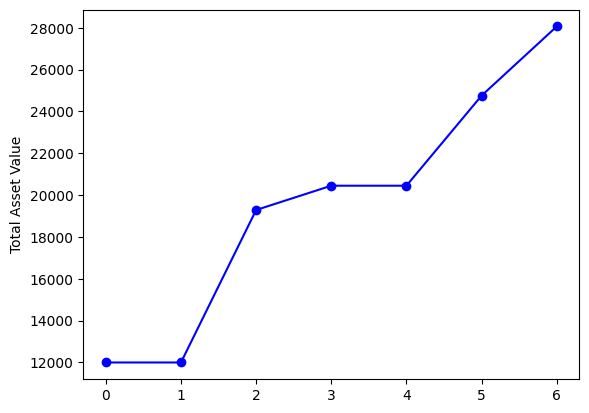

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:20:00, 2023-11-05 11:25:00]|ALXN|164.66            |180.2             |[2023-11-05 11:15:00, 2023-11-05 11:20:00]|
|[2023-11-05 11:45:00, 2023-11-05 11:50:00]|ALXN|127.81            |201.66995         |[2023-11-05 11:30:00, 2023-11-05 11:35:00]|
|[2023-11-05 11:55:00, 2023-11-05 12:00:00]|ALXN|104.12333333333333|139.99            |[2023-11-05 11:50:00, 2023-11-05 11:55:00]|
|[2023-11-05 11:10:00, 2023-11-05 11:15:00]|GIS |49.35666666666666 |50.5207           |[2023-11-05 11:05:00, 2023-11-05 11:10:00]|
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|GIS |48.6              |49.356666666666

+------------------------------------------+----+------------------+------------------+------------------------------------------+
|window                                    |name|avg(price)        |previous_price    |previous_window                           |
+------------------------------------------+----+------------------+------------------+------------------------------------------+
|[2023-11-05 11:15:00, 2023-11-05 11:20:00]|ALXN|180.2             |108.02            |[2023-11-05 11:10:00, 2023-11-05 11:15:00]|
|[2023-11-05 11:25:00, 2023-11-05 11:30:00]|ALXN|186.99            |164.66            |[2023-11-05 11:20:00, 2023-11-05 11:25:00]|
|[2023-11-05 11:30:00, 2023-11-05 11:35:00]|ALXN|201.66995         |186.99            |[2023-11-05 11:25:00, 2023-11-05 11:30:00]|
|[2023-11-05 11:50:00, 2023-11-05 11:55:00]|ALXN|139.99            |127.81            |[2023-11-05 11:45:00, 2023-11-05 11:50:00]|
|[2023-11-05 12:00:00, 2023-11-05 12:05:00]|ALXN|116.72            |104.12333333333

In [13]:
from matplotlib import pyplot as plt
import mplcursors

test = spark.sql("SELECT * FROM AssetValue1")
test = test.toPandas()
# Vẽ biểu đồ đường
plt.plot(test.index, test["total_asset_value"], marker='o', linestyle='-', color='b')
plt.ylabel("Total Asset Value")